<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/D1_CNN2_A3_dAugment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.applications import ResNet101
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
def preprocess_image(image_path):
    # Read grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to (224, 224)
    image = cv2.resize(image, (224, 224))
    # Convert grayscale to RGB by stacking the single channel
    image_rgb = np.stack((image,) * 3, axis=-1)
    # Preprocess image for ResNet50 model
    image_rgb = preprocess_input(image_rgb)
    return image_rgb

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define age ranges
age_ranges = [(1, 2), (3, 9), (10, 20), (21, 27), (28, 45), (46, 65), (66, 116)]

# Function to map age to range index
def age_to_range(age, age_ranges):
    for idx, (start, end) in enumerate(age_ranges):
        if start <= age <= end:
            return idx
    return None

In [6]:
def preprocess_labels(labels, num_classes):
    # One-hot encode labels
    labels = to_categorical(labels, num_classes=num_classes)
    return labels

In [7]:
# Load and preprocess the dataset
image_dir = '/content/drive/MyDrive/Dataset/part1'
images=[]
image_paths = []
age_labels = []
age_groups = []
target_size = (224, 224)

for i,filename in enumerate(os.listdir(image_dir)):
  if i>=100:
    break
  if filename.endswith(".jpg"):
    age = int(filename.split('_')[0])
    range_index = age_to_range(age, age_ranges)
    age_labels.append(range_index)

    image_path = os.path.join(image_dir, filename)
    image = preprocess_image(image_path)
    images.append(image)
    image_paths.append(image_path)

images = np.array(images)
age_groups = age_labels
age_labels = preprocess_labels(age_labels, len(age_ranges))

In [8]:
# Print shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {age_labels.shape}")

Images shape: (100, 224, 224, 3)
Labels shape: (100, 7)


In [9]:
def age_group_to_interval(group_index):
    if group_index < 0 or group_index >= len(age_ranges):
        return "Unknown"

    start, end = age_ranges[group_index]
    return f"{start}-{end}"

In [10]:
import pandas as pd
df = pd.DataFrame()
age_intervals = [age_group_to_interval(age) for age in age_groups]
df['images_path'],df['age'] = image_paths,age_intervals
df.head(10)

,images_path,age
0,/content/drive/MyDrive/Dataset/part1/28_1_0_20...,28-45
1,/content/drive/MyDrive/Dataset/part1/35_0_0_20...,28-45
2,/content/drive/MyDrive/Dataset/part1/38_0_4_20...,28-45
3,/content/drive/MyDrive/Dataset/part1/50_1_0_20...,46-65
4,/content/drive/MyDrive/Dataset/part1/20_1_2_20...,10-20
5,/content/drive/MyDrive/Dataset/part1/35_0_4_20...,28-45
6,/content/drive/MyDrive/Dataset/part1/57_0_0_20...,46-65
7,/content/drive/MyDrive/Dataset/part1/51_0_0_20...,46-65
8,/content/drive/MyDrive/Dataset/part1/36_1_0_20...,28-45
9,/content/drive/MyDrive/Dataset/part1/39_0_0_20...,28-45


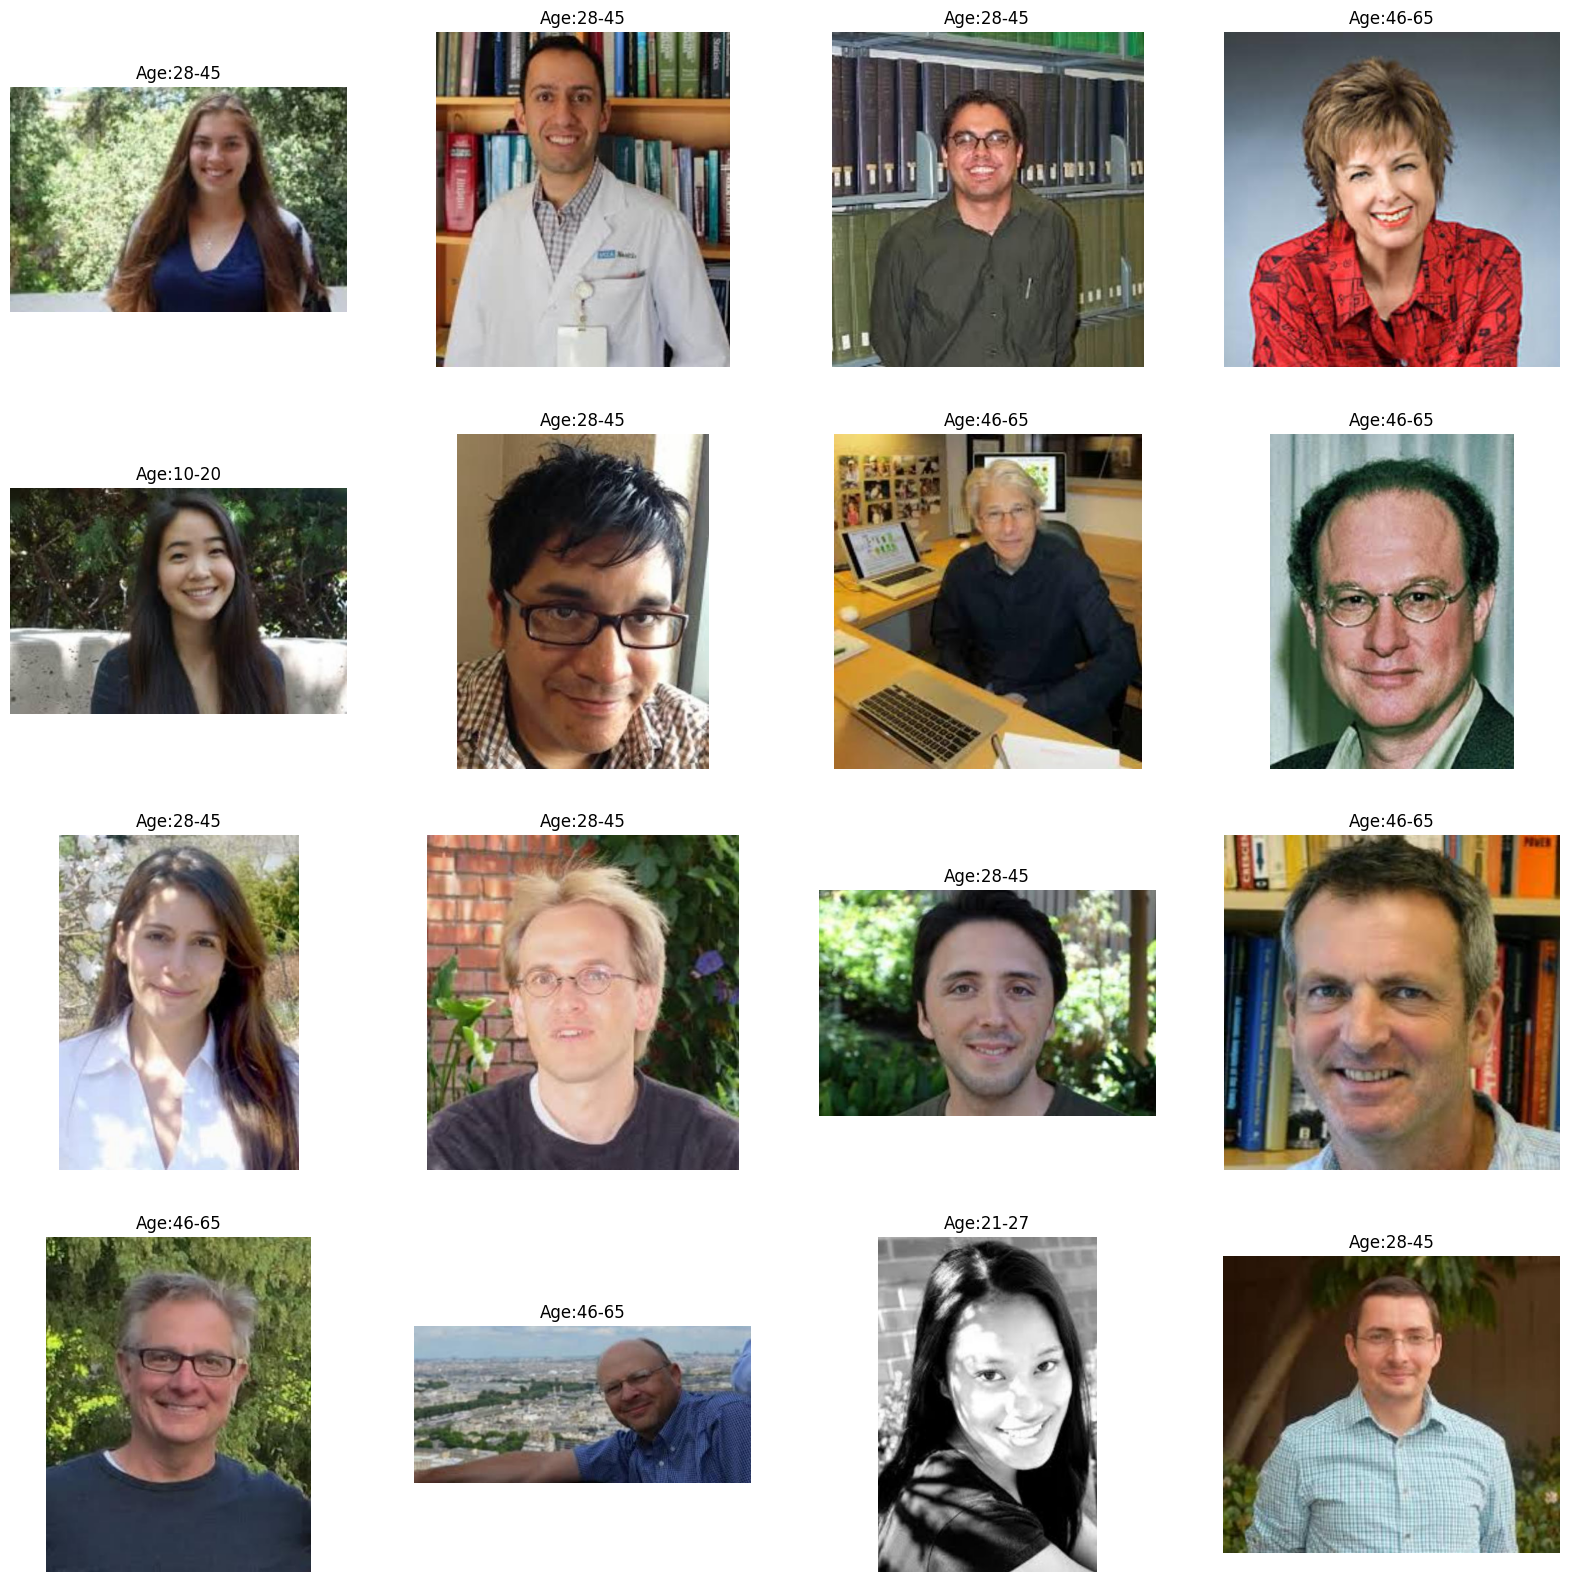

In [11]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

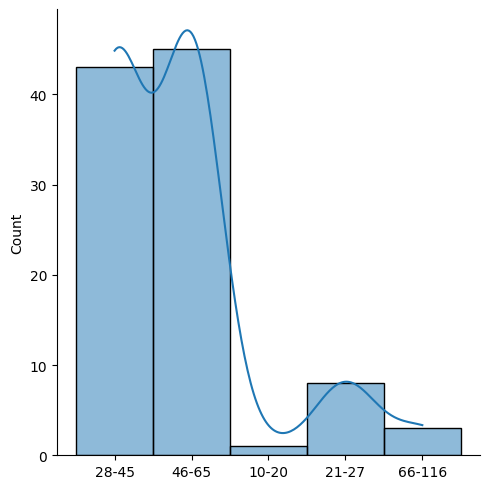

In [12]:
#age distribution
sns.displot(data=age_intervals,kde=True)

In [13]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_labels, test_size=0.2, random_state=42)


In [14]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [15]:
# Create training and validation generators
train_generator = datagen.flow(train_images, train_age_groups, batch_size=512, shuffle=False)  # Shuffle is False for reproducibility
val_generator = datagen.flow(test_images, test_age_groups, batch_size=512, shuffle=False)

In [16]:
# Load ResNet101 with pre-trained ImageNet weights, excluding the top layers
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

171446536/171446536 [==============================] - 8s 0us/step


In [17]:

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(132, activation='relu')(x)
predictions = Dense(len(age_ranges), activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/D1_CNN2_A3_dAugment.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)



In [19]:
model.fit(train_generator,validation_data=val_generator, epochs=60, callbacks=[model_checkpoint], shuffle=False)


Epoch 1/60
1/1 [==============================] - ETA: 0s - loss: 1.7847 - accuracy: 0.2375
Epoch 1: val_accuracy improved from -inf to 0.45000, saving model to /content/drive/MyDrive/Dataset/D1_CNN2_A3_dAugment.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 81s 81s/step - loss: 1.7847 - accuracy: 0.2375 - val_loss: 3.1093 - val_accuracy: 0.4500
Epoch 2/60
1/1 [==============================] - ETA: 0s - loss: 0.9127 - accuracy: 0.5500
Epoch 2: val_accuracy improved from 0.45000 to 0.50000, saving model to /content/drive/MyDrive/Dataset/D1_CNN2_A3_dAugment.h5
1/1 [==============================] - 4s 4s/step - loss: 0.9127 - accuracy: 0.5500 - val_loss: 5.3119 - val_accuracy: 0.5000
Epoch 3/60
1/1 [==============================] - ETA: 0s - loss: 1.0266 - accuracy: 0.6500
Epoch 3: val_accuracy did not improve from 0.50000
1/1 [==============================] - 2s 2s/step - loss: 1.0266 - accuracy: 0.6500 - val_loss: 14.9072 - val_accuracy: 0.4500
Epoch 4/60
1/1 [==============================] - ETA: 0s - loss: 1.0173 - accuracy: 0.6750
Epoch 4: val_accuracy did not improve from 0.50000
1/1 [==============================] - 2s 2s/step - loss: 1.0173 - accuracy: 0.6750 - val_loss: 15.3857 - val_accur

In [20]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/D1_CNN2_A3_dAugment.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(val_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


1/1 [==============================] - 0s 297ms/step - loss: 5.2416 - accuracy: 0.4500
Test Accuracy: 45.00%


In [21]:

predictions = model.predict(val_generator)

# Convert predictions to class labels if needed
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_age_groups, axis=1)

1/1 [==============================] - 2s 2s/step


In [22]:
# Example metrics calculation
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       0.41      0.78      0.54         9
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         1

    accuracy                           0.35        20
   macro avg       0.08      0.16      0.11        20
weighted avg       0.19      0.35      0.24        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.35
Precision: 0.19
Recall: 0.35
F1-score: 0.24


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Calculate accuracy for each class
class_accuracies = {}
for idx, (start, end) in enumerate(age_ranges):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[f'{start}-{end}'] = accuracy

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
